In [2]:
"""
Wallet Model Training & Explainability Notebook
================================================

End-to-end Jupyter/VS Code notebook that

1. Loads the **processed** dataset generated by *wallet_dataset_preprocessing.py*.
2. Splits the data, builds a preprocessing + Random Forest pipeline, and tunes
   hyper-parameters via `GridSearchCV`.
3. Evaluates the best model with a classification report & confusion matrix.
4. Offers two explainability blocks – **SHAP** (commented-out, optional) and
   **CIU** – for local feature influence.
5. Saves the trained pipeline (`joblib`) and the report (TXT) alongside the
   dataset for reproducibility.

Key improvements vs. the raw script:
* Uses a single `Pipeline` so the GridSearch tunes the classifier only and keeps
  preprocessing fixed.
* Retrieves feature names automatically via
  `preprocessor.get_feature_names_out()` – works even with mixed types.
* Handles older scikit-learn versions: falls back to `sparse=False` if
  `sparse_output` isn’t available.
* Cleans up unused variables and fixes the invalid attempt to access `.index`
  on NumPy arrays.
* Adds **environment variables** (`DATASET_PATH`, `MODEL_DIR`) to override
  defaults without editing code.
"""

'\nWallet Model Training & Explainability Notebook\n================================================\n\nEnd-to-end Jupyter/VS Code notebook that\n\n1. Loads the **processed** dataset generated by *wallet_dataset_preprocessing.py*.\n2. Splits the data, builds a preprocessing + Random Forest pipeline, and tunes\n   hyper-parameters via `GridSearchCV`.\n3. Evaluates the best model with a classification report & confusion matrix.\n4. Offers two explainability blocks – **SHAP** (commented-out, optional) and\n   **CIU** – for local feature influence.\n5. Saves the trained pipeline (`joblib`) and the report (TXT) alongside the\n   dataset for reproducibility.\n\nKey improvements vs. the raw script:\n* Uses a single `Pipeline` so the GridSearch tunes the classifier only and keeps\n  preprocessing fixed.\n* Retrieves feature names automatically via\n  `preprocessor.get_feature_names_out()` – works even with mixed types.\n* Handles older scikit-learn versions: falls back to `sparse=False` if\n  

In [ ]:
# ----------------------------------------------------------------------
# Configuration – edit paths or set env-vars before starting Jupyter
# ----------------------------------------------------------------------
from __future__ import annotations

import os
from pathlib import Path
import warnings

DATASET_PATH = Path(os.getenv(
    "DATASET_PATH",
    "../../data/processed_data/case_3.csv",
))
MODEL_DIR = Path(os.getenv("MODEL_DIR", DATASET_PATH.parent / "models"))
MODEL_DIR.mkdir(parents=True, exist_ok=True)

REPORT_FILE = MODEL_DIR / "classification_report.txt"
MODEL_FILE  = MODEL_DIR / "rf_pipeline.joblib"

print(f"📄 Dataset: {DATASET_PATH}\n📂 Model dir: {MODEL_DIR}\n")

📄 Dataset: ../../data/processed_data/case_3.csv
📂 Model dir: ../../data/processed_data/models



In [4]:
# ----------------------------------------------------------------------
# Imports – ML stack & utilities
# ----------------------------------------------------------------------
import logging
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # optional for nicer confusion matrix

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Optional explainability libs
# import shap  # uncomment if you plan to use SHAP
import ciu
from IPython.display import display

warnings.filterwarnings("ignore", category=FutureWarning)
logging.basicConfig(level=logging.INFO, format="%(asctime)s – %(levelname)s – %(message)s")
logger = logging.getLogger(__name__)

In [5]:
# ----------------------------------------------------------------------
# Load dataset
# ----------------------------------------------------------------------
logger.info("Loading dataset…")
df = pd.read_csv(DATASET_PATH)
logger.info(f"Dataset shape: {df.shape}")

X = df.drop(columns="class")
y = df["class"]

2025-06-03 16:45:14,019 – INFO – Loading dataset…
2025-06-03 16:45:14,042 – INFO – Dataset shape: (13495, 22)


In [6]:
# ----------------------------------------------------------------------
# Identify numeric & categorical columns
# ----------------------------------------------------------------------
numeric_features      = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features  = X.select_dtypes(include=["object", "category"]).columns.tolist()
logger.info(f"Numeric  : {len(numeric_features)} columns")
logger.info(f"Categorical: {len(categorical_features)} columns")

2025-06-03 16:45:14,048 – INFO – Numeric  : 21 columns
2025-06-03 16:45:14,048 – INFO – Categorical: 0 columns


In [7]:
# ----------------------------------------------------------------------
# Preprocessing pipelines
# ----------------------------------------------------------------------
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

# Handle API change for OneHotEncoder (sparse_output introduced in 1.2)
onehot_kwargs = {"handle_unknown": "ignore"}
if "sparse_output" in OneHotEncoder.__init__.__code__.co_varnames:
    onehot_kwargs["sparse_output"] = False
else:
    onehot_kwargs["sparse"] = False

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(**onehot_kwargs)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [8]:
# ----------------------------------------------------------------------
# Model & pipeline
# ----------------------------------------------------------------------
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", rf)])

param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 20],
    "classifier__min_samples_split": [2, 5],
    "classifier__min_samples_leaf": [1, 2],
    "classifier__max_features": ["sqrt"],
}

In [9]:
# ----------------------------------------------------------------------
# Train / validation split & GridSearch
# ----------------------------------------------------------------------
le = LabelEncoder()
y_encoded = le.fit_transform(y)

logger.info("Splitting train/test…")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

logger.info("Starting GridSearchCV…")
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2,
)

grid_search.fit(X_train, y_train)
logger.info(f"Best params: {grid_search.best_params_}")

best_model = grid_search.best_estimator_

2025-06-03 16:45:14,060 – INFO – Splitting train/test…
2025-06-03 16:45:14,063 – INFO – Starting GridSearchCV…


Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   1.9s
[CV] END classifier__max_depth=None, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=100; total time=   2.0s
[CV] END classifier__max_dept

2025-06-03 16:45:33,956 – INFO – Best params: {'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}


2025-06-03 16:45:33,989 – INFO – Classification report saved → ../../data/processed_data/models/classification_report.txt


              precision    recall  f1-score   support

       fraud       0.93      0.92      0.92      1269
       licit       0.93      0.93      0.93      1430

    accuracy                           0.93      2699
   macro avg       0.93      0.92      0.93      2699
weighted avg       0.93      0.93      0.93      2699



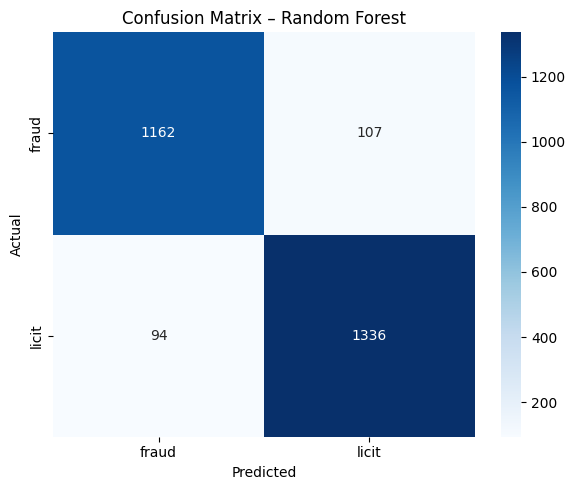

In [10]:
# ----------------------------------------------------------------------
# Evaluation
# ----------------------------------------------------------------------
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=le.classes_)
cm      = confusion_matrix(y_test, y_pred)

print(report)

# Save the textual report
REPORT_FILE.write_text(report)
logger.info(f"Classification report saved → {REPORT_FILE}")

# Confusion matrix plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix – Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [11]:
# ----------------------------------------------------------------------
# Persist the trained pipeline
# ----------------------------------------------------------------------
joblib.dump(best_model, MODEL_FILE)
logger.info(f"Model pipeline saved → {MODEL_FILE}")

# %% [markdown]
"""
## 🔍 Local Explainability with CIU
Below cells provide a ready‑made block to analyse feature influence for a
single test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).

*Change `instance_idx` to explore different samples.*
"""

2025-06-03 16:45:34,127 – INFO – Model pipeline saved → ../../data/processed_data/models/rf_pipeline.joblib


'\n## 🔍 Local Explainability with CIU\nBelow cells provide a ready‑made block to analyse feature influence for a\nsingle test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).\n\n*Change `instance_idx` to explore different samples.*\n'


## 🔍 Local Explainability with CIU
Below cells provide a ready‑made block to analyse feature influence for a
single test instance using CIU ([*Contextual Importance & Utility*](https://github.com/TrustAI/py‑ciu)).

*Change `instance_idx` to explore different samples.*


=== CIU – local explanation ===


,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
time_interval_ratio,0.01,0.0,-0.005,fraud,0.0,time_interval_ratio,0.0,0.01,[18],[0.3771420122849211],0.5,None,None
total_sent,0.01,0.0,-0.005,fraud,0.0,total_sent,0.0,0.01,[7],[5808.785313089999],0.5,None,None
volume_ratio,0.01,0.0,-0.005,fraud,0.0,volume_ratio,0.0,0.01,[15],[83.34766078869117],0.5,None,None
avg_out_time_interval,0.03,0.0,-0.015,fraud,0.0,avg_out_time_interval,0.0,0.03,[10],[0.0317076109099611],0.5,None,None
avg_in_transaction,0.04,0.0,-0.020,fraud,0.0,avg_in_transaction,0.0,0.04,[4],[0.8117045959578012],0.5,None,None
avg_out_transaction,0.04,0.0,-0.020,fraud,0.0,avg_out_transaction,0.0,0.04,[5],[0.0320414370864416],0.5,None,None
in_out_ratio,0.05,0.0,-0.025,fraud,0.0,in_out_ratio,0.0,0.05,[12],[37.29184247533433],0.5,None,None
weighted_avg_tx,0.05,0.0,-0.025,fraud,0.0,weighted_avg_tx,0.0,0.05,[19],[0.7913435188073971],0.5,None,None
unique_out_ratio,0.07,0.0,-0.035,fraud,0.0,unique_out_ratio,0.0,0.07,[14],[0.6232067510539758],0.5,None,None
total_received,0.08,0.0,-0.040,fraud,0.0,total_received,0.0,0.08,[6],[484148.66787059],0.5,None,None


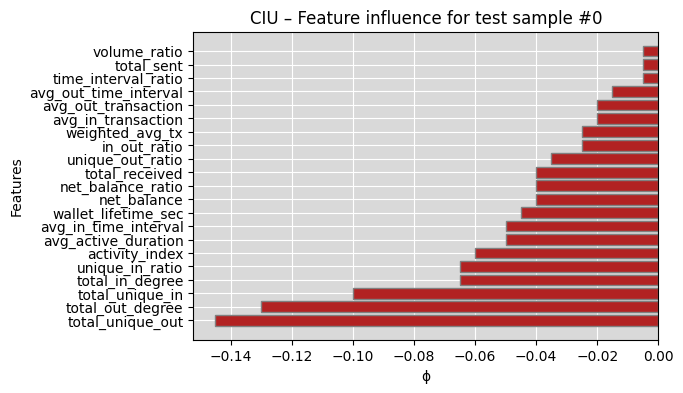

'\n### Optional: SHAP values\nUncomment the following cell if you prefer SHAP for global explanations (may be\nslow on large datasets):\n```python\nimport shap\n\n```\n'

In [20]:
# ----------------------------------------------------------------------
# CIU explainability block – run as needed
# ----------------------------------------------------------------------
from ciu import CIU

# Fit CIU on the original (non‑encoded) data – requires category mapping
category_mapping = {c: X[c].unique().tolist() for c in categorical_features}

ciu_explainer = CIU(
    predictor        = best_model.predict_proba,
    data             = X_train,  # range estimations
    input_names      = best_model.named_steps["preprocessor"].get_feature_names_out(),
    out_names        = le.classes_.tolist(),
    category_mapping = category_mapping,
    neutralCU        = 0.5,
    output_inds      = [0],  # index of positive class
)

# Pick an instance to explain
instance_idx = 0

sample_raw  = X_test.iloc[[instance_idx]]
ciu_result  = ciu_explainer.explain(sample_raw)

print("\n=== CIU – local explanation ===")
display(ciu_result.sort_values("Cinfl", ascending=False))

ciu_explainer.plot_influence(
    ciu_result,
    main=f"CIU – Feature influence for test sample #{instance_idx}",
)
plt.show()

# %% [markdown]
"""
### Optional: SHAP values
Uncomment the following cell if you prefer SHAP for global explanations (may be
slow on large datasets):
```python
import shap

```
"""


In [ ]:
import shap

# # -------- Option A: generic Explainer on Pipeline.predict --------
# logger.info("Computing SHAP values (generic Explainer)…")
# explainer   = shap.Explainer(best_model.predict, X_train, feature_names=X.columns)
# shap_values = explainer(X_train)

# shap.plots.beeswarm(shap_values, max_display=20)  # global importance

# -------- Option B: TreeExplainer on RF + encoded data --------
logger.info("Computing SHAP values (TreeExplainer)…")
X_train_enc   = best_model.named_steps['preprocessor'].transform(X_train)
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
explainer     = shap.TreeExplainer(best_model.named_steps['classifier'])
shap_values   = explainer.shap_values(X_train_enc)

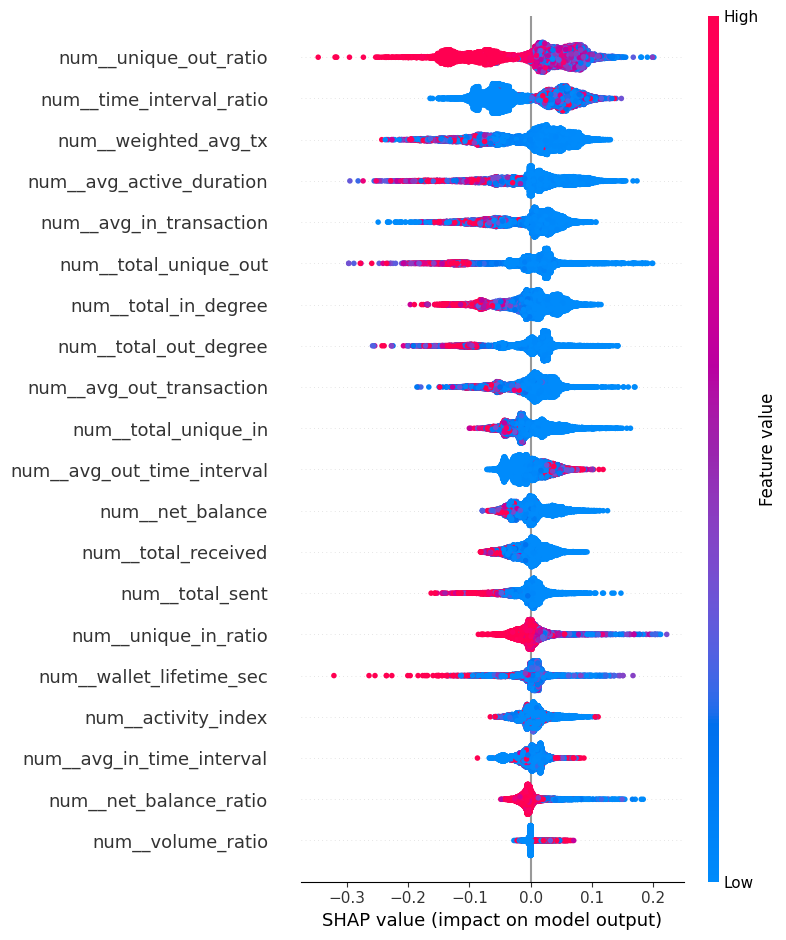

In [21]:
shap.summary_plot(shap_values[:, :, 0], 
                  features=X_train_enc, 
                  feature_names=feature_names,
                  max_display=20)
